In [1]:
!pip install scikit-learn pandas numpy xgboost lightgbm imbalanced-learn

In [2]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
from google.colab import files
print("Please upload your survey CSV file...")
uploaded = files.upload()

# Get the filename
csv_filename = list(uploaded.keys())[0]
print(f"\nLoaded file: {csv_filename}")

Please upload your survey CSV file...


Saving expanded_survey_data.csv to expanded_survey_data.csv

Loaded file: expanded_survey_data.csv


In [4]:
df = pd.read_csv(csv_filename)
print(f"\nDataset Shape: {df.shape}")
print(f"\nColumn Names:\n{df.columns.tolist()}")
print(f"\nFirst 5 rows:\n{df.head()}")



Dataset Shape: (3000, 75)

Column Names:
['Time taken', 'source', 'Source details', 'From IP', 'Total points', '1. What is your software company name? (Optional)', '2. How big is your organization?', '3. What type of software development does your company focus on? (Multiple choice) (Web page development)', '3. (Mobile application development)', '3. (Artificial Intelligence/Machine Learning Solutions)', '3. (Cybersecurity Solution)', '3. (Cloud computing service)', '3. (Game Development)', '4. How long has your company been operating?', '5. What types of risks does your software company usually face? (Multiple choice) (Financial risk (budget overspending, funding issues))', '5. (Operational risk (ine efficiency of process, poor management))', '5. (Strategic risk (market competition, project failure))', '5. (Technical risk (system failure, network security threat))', '5. (Compliance Risk (Legal and Regulatory Issues))', '5. (Others (please specify) __________)', '6. How often will your

In [5]:
# metadata columns to exclude
metadata_cols = ['Time taken', 'source', 'Source details', 'From IP', 'Total points']

# company name column (exclude from features but keep for DB)
company_name_col = '1. What is your software company name? (Optional)'

# target column
target_col = '7. Which risk has had the most significant impact on your business over the past year?'

# Get all columns
all_cols = df.columns.tolist()

# Remove metadata and company name from features
feature_cols = [col for col in all_cols if col not in metadata_cols + [company_name_col, target_col]]

print(f"\n{'='*60}")
print(f"Feature columns count: {len(feature_cols)}")
print(f"Target column: {target_col}")
print(f"{'='*60}")


Feature columns count: 68
Target column: 7. Which risk has had the most significant impact on your business over the past year?


In [6]:
X = df[feature_cols].fillna(0)

# Target variable
y = df[target_col].fillna('Unknown')

# Check target distribution
print(f"\nTarget Variable Distribution:")
print(y.value_counts())
print(f"\nUnique risk categories: {y.nunique()}")


Target Variable Distribution:
7. Which risk has had the most significant impact on your business over the past year?
No                                                                                              450
Strategic risk                                                                                  300
Loss                                                                                            150
Project churn                                                                                   150
Project competition                                                                             150
Information security                                                                            150
Technology updates too fast                                                                     150
Financial risk                                                                                  150
Market competition, customer demand changes                                       

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 2400
Test set size: 600


In [11]:
print(f"\n{'='*60}")
print("Encoding categorical columns...")
print(f"{'='*60}")

# Identify non-numeric columns
non_numeric_cols = X_train.select_dtypes(include=['object']).columns.tolist()
print(f"\nFound {len(non_numeric_cols)} categorical columns to encode")

if len(non_numeric_cols) > 0:
    print(f"Categorical columns: {non_numeric_cols[:68]}...")  # Show first 5

    # One-hot encode training data
    X_train_encoded = pd.get_dummies(X_train, columns=non_numeric_cols, drop_first=False)

    # One-hot encode test data
    X_test_encoded = pd.get_dummies(X_test, columns=non_numeric_cols, drop_first=False)

    # Align test set columns with training set
    missing_cols = set(X_train_encoded.columns) - set(X_test_encoded.columns)
    for col in missing_cols:
        X_test_encoded[col] = 0

    # Ensure same column order
    X_test_encoded = X_test_encoded[X_train_encoded.columns]

    # Update feature columns list for saving
    feature_cols = X_train_encoded.columns.tolist()

    print(f"\n Encoding complete!")
    print(f"New feature count: {len(feature_cols)}")

    # Replace X_train and X_test with encoded versions
    X_train = X_train_encoded
    X_test = X_test_encoded
else:
    print("\n No categorical columns found - all features are numeric")

print(f"\nFinal Training Shape: {X_train.shape}")
print(f"Final Test Shape: {X_test.shape}")


Encoding categorical columns...

Found 0 categorical columns to encode

 No categorical columns found - all features are numeric

Final Training Shape: (2400, 85)
Final Test Shape: (600, 85)



Training RandomForestClassifier...


Top 20 Important Features:
                                              feature  importance
38  15. With 1 to 5 as the level, how serious is f...    0.025751
51  20. How does your organization evaluate and cl...    0.024655
58  22. How effective do you think your current ri...    0.024270
15  8. How often will your company face project de...    0.024154
26  11. How does your team usually respond when th...    0.022532
33  14. With 1 to 5 as the level, how severe is th...    0.021918
22  10. (Use project management tools (such as Jir...    0.021632
9   5. (Operational risk (ine efficiency of proces...    0.021429
10  5. (Strategic risk (market competition, projec...    0.021269
36                                14. Technical risks    0.020130
1   3. What type of software development does your...    0.019394
43  19. (Operational risks (such as inefficiency, ...    0.018918
48  19. (Customer and contract risks (such as cont...    0.018651
74  23. Wha

/tmp/ipython-input-59641598.py:58: UserWarning: Glyph 151 (\x97) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-59641598.py:58: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


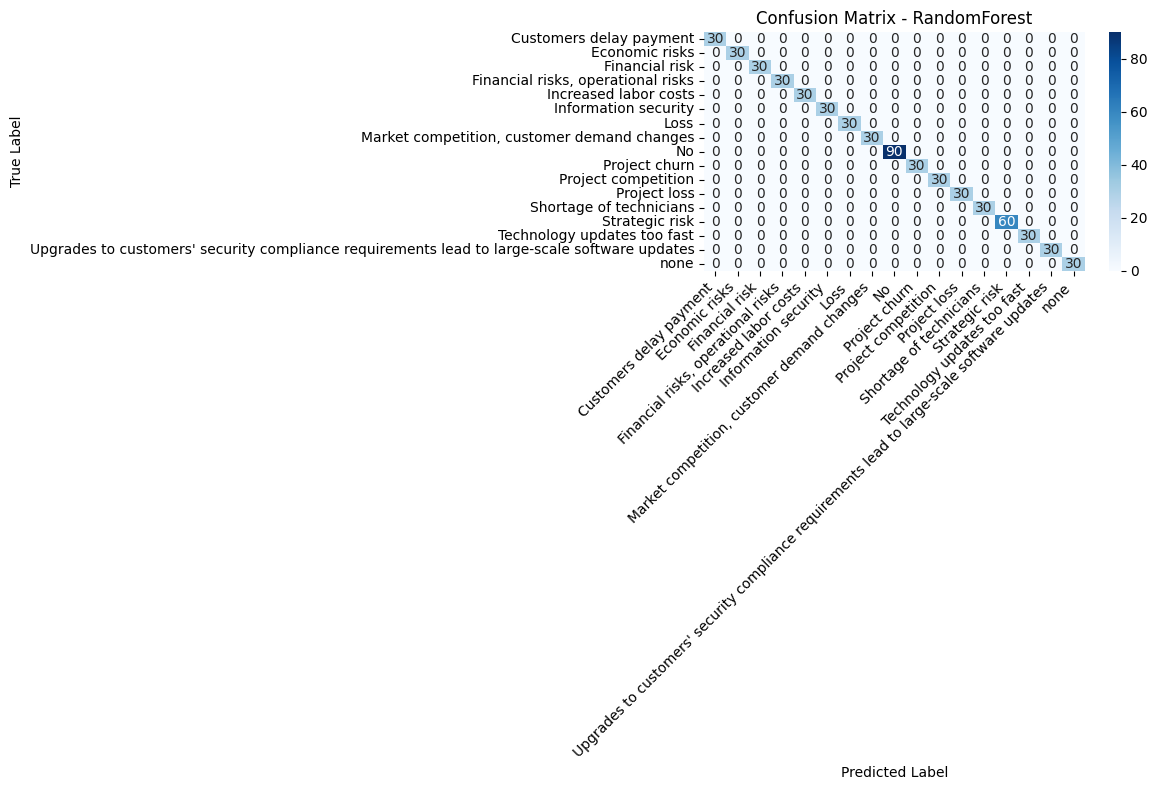

<Figure size 1000x800 with 0 Axes>

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 151 (\x97) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


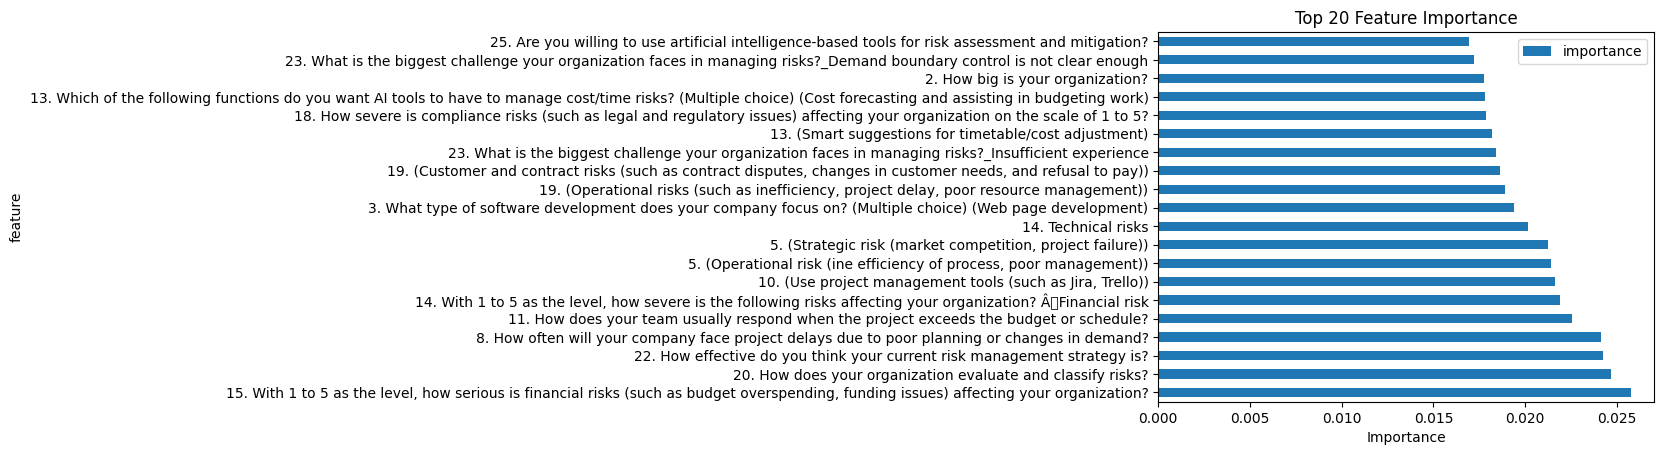

In [13]:
print(f"\n{'='*60}")
print("Training RandomForestClassifier...")
print(f"{'='*60}")

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print(f"\n{'='*60}")
# print("RandomForest Model Evaluation")
# print(f"{'='*60}")
# print(f"\nAccuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
# print(f"\nClassification Report:\n{classification_report(y_test, y_pred_rf)}")

# Cross-validation score
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')
# print(f"\nCross-Validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# Confusion Matrix
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=rf_model.classes_,
            yticklabels=rf_model.classes_)
plt.title('Confusion Matrix - RandomForest')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()


# Feature Importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 20 Important Features:")
print(feature_importance.head(20))

# Plot feature importance
plt.figure(figsize=(10, 8))
feature_importance.head(20).plot(x='feature', y='importance', kind='barh')
plt.title('Top 20 Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

In [15]:
print(f"\n{'='*60}")
print("Training XGBoost Model ...")
print(f"{'='*60}")

# Encode labels for XGBoost
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)

xgb_model.fit(X_train, y_train_encoded)
y_pred_xgb = xgb_model.predict(X_test)



Training XGBoost Model ...


In [18]:

print("Cleaning column names for LightGBM compatibility...")


# Remove special characters from column names
X_train.columns = X_train.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
X_test.columns = X_test.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)

# Update feature_cols list
feature_cols = X_train.columns.tolist()

print(f"Column names cleaned!")
print(f"Sample cleaned columns: {feature_cols[:3]}")

Cleaning column names for LightGBM compatibility...
Column names cleaned!
Sample cleaned columns: ['2_How_big_is_your_organization_', '3_What_type_of_software_development_does_your_company_focus_on_Multiple_choice_Web_page_development_', '3_Mobile_application_development_']


In [19]:
print(f"\n{'='*60}")
print("Training LightGBM Model...")
print(f"{'='*60}")

lgb_model = lgb.LGBMClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)



Training LightGBM Model...


In [26]:
print(f"\n{'='*60}")
print("Model Comparison:")
print(f"{'='*60}")
print(f"RandomForest Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"XGBoost Accuracy: {accuracy_score(y_test_encoded, y_pred_xgb):.4f}")
print(f"LightGBM Accuracy: {accuracy_score(y_test, y_pred_lgb):.4f}")

final_model = rf_model
model_name = "XGBoost"

print(f"\nSelected Model: {model_name}")


Model Comparison:
RandomForest Accuracy: 1.0000
XGBoost Accuracy: 1.0000
LightGBM Accuracy: 1.0000

Selected Model: XGBoost


In [22]:
# Save the trained model
with open('risk_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)
print("\n Model saved as 'risk_model.pkl'")

# Save feature column names
with open('train_columns.pkl', 'wb') as f:
    pickle.dump(feature_cols, f)
print("Feature columns saved as 'train_columns.pkl'")

# Save label encoder (if using XGBoost)
if model_name == "XGBoost":
    with open('label_encoder.pkl', 'wb') as f:
        pickle.dump(le, f)
    print("Label encoder saved as 'label_encoder.pkl'")


 Model saved as 'risk_model.pkl'
Feature columns saved as 'train_columns.pkl'


In [24]:
from google.colab import files

print("Downloading model files to your local machine...")

files.download('risk_model.pkl')
files.download('train_columns.pkl')

if model_name == "XGBoost":
    files.download('label_encoder.pkl')

print("\n Training Complete!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


 Training Complete!
